# Отчетность по среднему чеку

Данные представляют из себя датасет с выборкой клиентов, которые совершают различные банковские операции в различных валютах и для различных целей.

- mcc - код
- period - месяц и год проведения транзации
- trdatetime - точная дата и время проведения транзации
- amount - сумма транзакции
- channel_type - тип канала
- cl_id - id клиента
- currency - валюта 
- trx_category - категория транзакции

## Загрузка и первичный осмотр данных

In [1]:
import pandas as pd
import numpy as np
import random

In [2]:
# Установка опции отображения для максимального количества столбцов
pd.set_option('display.max_columns', None)

import warnings
warnings.simplefilter("ignore")

In [3]:
df = pd.read_csv('data.csv')

In [4]:
df.head()

,mcc,period,trdatetime,amount,channel_type,cl_id,currency,trx_category
0,5200,01/10/2017,21OCT17:00:00:00,5023.0,NaN,0,810,POS
1,6011,01/10/2017,12OCT17:12:24:07,20000.0,NaN,0,810,DEPOSIT
2,5921,01/12/2017,05DEC17:00:00:00,767.0,NaN,0,810,POS
3,5411,01/10/2017,21OCT17:00:00:00,2031.0,NaN,0,810,POS
4,6012,01/10/2017,24OCT17:13:14:24,36562.0,NaN,0,810,C2C_OUT


In [5]:
'%s строк и %s столбцов'%df.shape

'1008889 строк и 8 столбцов'

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1008889 entries, 0 to 1008888
Data columns (total 8 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   mcc           1008889 non-null  int64  
 1   period        1008889 non-null  object 
 2   trdatetime    1008889 non-null  object 
 3   amount        1008889 non-null  float64
 4   channel_type  1003825 non-null  object 
 5   cl_id         1008889 non-null  int64  
 6   currency      1008889 non-null  int64  
 7   trx_category  1008889 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 61.6+ MB


In [7]:
df.channel_type.unique()

array([nan, 'type5', 'type4', 'type2', 'type3', 'type1'], dtype=object)

Поле channel_type закодировано, а также имеет нулевые значения. 

In [8]:
df = df.drop(columns='channel_type')

Произведем подсчет количества уникальных валют в датасете

In [9]:
'Количество уникальных валют в датасете: %s'% len(df['currency'].unique())

'Количество уникальных валют в датасете: 67'

Рассмотрим имеющиеся типы категорий транзакций

In [10]:
df['trx_category'].unique()

array(['POS', 'DEPOSIT', 'C2C_OUT', 'WD_ATM_ROS', 'BACK_TRX',
       'WD_ATM_PARTNER', 'WD_ATM_OTHER', 'C2C_IN', 'CAT', 'CASH_ADV'],
      dtype=object)

- POS (Point of Sale) — транзакции, проведенные через терминалы в торговых точках (магазины, рестораны и т. д.). Это означает, что вы использовали карту для оплаты товаров или услуг.

- DEPOSIT — депозит, то есть внесение средств на счет. Это может быть пополнение счета наличными, перевод от другого лица, зачисление зарплаты и т. д.

- C2C_OUT (Customer to Customer Outgoing) — исходящий перевод средств от одного клиента другому, например, перевод денег с вашего счета на счет другого человека.

- WD_ATM_ROS — снятие наличных в банкомате, который принадлежит банку или находится в сети банкоматов данного банка (внутри страны). "ROS" может указывать на локальную сеть банкоматов.

- BACK_TRX (Back Transaction) — обратная транзакция, чаще всего означает возврат средств на счет (например, возврат за отмененную покупку или ошибочную транзакцию).

- WD_ATM_PARTNER — снятие наличных в банкомате, который принадлежит банку-партнеру (не основному банку клиента, но в партнерской сети).

- WD_ATM_OTHER — снятие наличных в банкомате, который не принадлежит ни основному банку, ни банку-партнеру. Обычно это приводит к дополнительным комиссиям.

- C2C_IN (Customer to Customer Incoming) — входящий перевод средств от другого клиента. Это когда кто-то переводит деньги на ваш счет.

- CAT (Card to Account Transfer) — перевод средств с карты на счет. Это может быть, например, перевод денег с вашей дебетовой карты на ваш же счет в банке.

- CASH_ADV (Cash Advance) — получение наличных средств через кассу банка или снятие в банкомате с использованием кредитной карты. Такая операция обычно сопровождается высокой комиссией и более высокими процентными ставками.

## Подготовка данных

Преобразуем формат даты колонок "period" и "trdatetime" в другой вид.

Создадим отдельные колонки для года/месяца/дня/времени и соединим месяц с годом, для удобства группировки.

Изменение формата столбца "period"

In [11]:
df['period'] = pd.to_datetime(df['period'], format='%d/%m/%Y')

Создание дополнительных столбцов со временем (часы и минуты), годом, месяцем, днем из столбца "trdatetime"

In [12]:
df['transac_time'] = df['trdatetime'].str[8:]

df['transac_day'] = df['trdatetime'].str[:2]

month_dict={'JAN':'01', 'FEB':'02', 'MAR':'03', 'APR':'04', 'MAY':'05', 'JUN':'06',
            'JUL':'07', 'AUG':'08', 'SEP':'09', 'OCT':'10', 'NOV':'11', 'DEC':'12'}
df['transac_month'] = df['trdatetime'].str[2:5].map(month_dict)

df['transac_year'] = '20'+df['trdatetime'].str[5:7]

Создание комбинированного столбца год-месяц

In [13]:
df['transac_year_month'] = '20'+df['trdatetime'].str[5:7]+'-'+df['trdatetime'].str[2:5].map(month_dict)

In [14]:
df.head()

,mcc,period,trdatetime,amount,cl_id,currency,trx_category,transac_time,transac_day,transac_month,transac_year,transac_year_month
0,5200,2017-10-01,21OCT17:00:00:00,5023.0,0,810,POS,00:00:00,21,10,2017,2017-10
1,6011,2017-10-01,12OCT17:12:24:07,20000.0,0,810,DEPOSIT,12:24:07,12,10,2017,2017-10
2,5921,2017-12-01,05DEC17:00:00:00,767.0,0,810,POS,00:00:00,05,12,2017,2017-12
3,5411,2017-10-01,21OCT17:00:00:00,2031.0,0,810,POS,00:00:00,21,10,2017,2017-10
4,6012,2017-10-01,24OCT17:13:14:24,36562.0,0,810,C2C_OUT,13:14:24,24,10,2017,2017-10


Посмотрим на статистику размеров транзакций по валютам

In [15]:
df.groupby('currency')['amount'].agg(['min', 'mean', 'median','max'])

,min,mean,median,max
currency,,,,
32,55.00,2469.582308,560.000,17546.28
36,1.00,64.860000,16.885,502.00
44,16.07,24.575000,24.575,33.08
48,5.00,17.000000,17.000,29.00
51,200.00,22946.801210,9424.000,196000.00
...,...,...,...,...
978,0.01,105.797974,29.000,9690.00
980,1.50,885.639098,282.000,15451.17
981,0.80,94.718251,35.620,1306.00


По числовым кодам непонятно с какой валютой происходит транзакция. Необходимо расшифровать их.

### Расшифровка кодов валют (Парсинг данных)

Необходимая таблица с кодами валют и их расшифровкой находится в Википедии. 

In [16]:
import requests
from bs4 import BeautifulSoup
import re

In [17]:
url = 'https://en.wikipedia.org/wiki/ISO_4217'
page = requests.get(url)
page.status_code

200

In [18]:
soup = BeautifulSoup(page.text, 'html.parser')
soup

<!DOCTYPE html>

<html class="client-nojs vector-feature-language-in-header-enabled vector-feature-language-in-main-page-header-disabled vector-feature-sticky-header-disabled vector-feature-page-tools-pinned-disabled vector-feature-toc-pinned-clientpref-1 vector-feature-main-menu-pinned-disabled vector-feature-limited-width-clientpref-1 vector-feature-limited-width-content-enabled vector-feature-custom-font-size-clientpref-1 vector-feature-appearance-enabled vector-feature-appearance-pinned-clientpref-1 vector-feature-night-mode-enabled skin-theme-clientpref-day vector-toc-available" dir="ltr" lang="en">
<head>
<meta charset="utf-8"/>
<title>ISO 4217 - Wikipedia</title>
<script>(function(){var className="client-js vector-feature-language-in-header-enabled vector-feature-language-in-main-page-header-disabled vector-feature-sticky-header-disabled vector-feature-page-tools-pinned-disabled vector-feature-toc-pinned-clientpref-1 vector-feature-main-menu-pinned-disabled vector-feature-limite

При просмотре кода страницы выяснилось, что таблица с кодами находится в теге table и принадлежит классу "wikitable sortable mw-collapsible"

In [19]:
table = soup.find('table', {'class':'wikitable sortable mw-collapsible'})
table

<table class="wikitable sortable mw-collapsible">
<caption>Active ISO 4217 currency codes<sup class="reference" id="cite_ref-ISO4217_1-4"><a href="#cite_note-ISO4217-1"><span class="cite-bracket">[</span>1<span class="cite-bracket">]</span></a></sup>
</caption>
<tbody><tr>
<th>Code</th>
<th>Num</th>
<th><span class="nowrap">D<sup class="reference" id="cite_ref-MinorUnits_6-0"><a href="#cite_note-MinorUnits-6"><span class="cite-bracket">[</span>a<span class="cite-bracket">]</span></a></sup></span></th>
<th>Currency</th>
<th><span class="nowrap">Locations listed for this currency<sup class="reference" id="cite_ref-7"><a href="#cite_note-7"><span class="cite-bracket">[</span>b<span class="cite-bracket">]</span></a></sup></span>
</th></tr>
<tr>
<td>AED</td>
<td>784</td>
<td>2</td>
<td><a href="/wiki/United_Arab_Emirates_dirham" title="United Arab Emirates dirham">United Arab Emirates dirham</a></td>
<td><span class="flagicon"><span class="mw-image-border" typeof="mw:File"><span><img alt=""

Все значения кодов и их расшифровки содержатся в тегах td.../td

Создадим переменные, которые будут содержать в себе коды валют, текстовые коды валют и текстовое поле, где лежит полная текстовая расшифровка (например российский рубль, австралийский доллар).

In [20]:
currency_codes = table.findAll('td')[::5]
number_codes = table.findAll('td')[1::5]
titles = table.findAll('td')[3::5]

In [21]:
all_codes = zip(currency_codes,number_codes,titles)
list(all_codes)

[(<td>AED</td>,
  <td>784</td>,
  <td><a href="/wiki/United_Arab_Emirates_dirham" title="United Arab Emirates dirham">United Arab Emirates dirham</a></td>),
 (<td>AFN</td>,
  <td>971</td>,
  <td><a href="/wiki/Afghan_afghani" title="Afghan afghani">Afghan afghani</a></td>),
 (<td>ALL</td>,
  <td>008</td>,
  <td><a href="/wiki/Albanian_lek" title="Albanian lek">Albanian lek</a></td>),
 (<td>AMD</td>,
  <td>051</td>,
  <td><a href="/wiki/Armenian_dram" title="Armenian dram">Armenian dram</a></td>),
 (<td>ANG</td>,
  <td>532</td>,
  <td><a href="/wiki/Netherlands_Antillean_guilder" title="Netherlands Antillean guilder">Netherlands Antillean guilder</a></td>),
 (<td>AOA</td>,
  <td>973</td>,
  <td><a href="/wiki/Angolan_kwanza" title="Angolan kwanza">Angolan kwanza</a></td>),
 (<td>ARS</td>,
  <td>032</td>,
  <td><a href="/wiki/Argentine_peso" title="Argentine peso">Argentine peso</a></td>),
 (<td>AUD</td>,
  <td>036</td>,
  <td><a href="/wiki/Australian_dollar" title="Australian dollar">A

**Создадим таблицы из полученных данных**

currency_codes и number_codes находятся внутри тэга td../td

Для заголовков titles существует 2 варианта:

- Когда есть ссылка и тогда достаем название через регулярное выражение и тэг title
- Ссылки нет и все это лежит как обычная строка в тэгах td../td 

In [22]:
clean_currency_codes = []
clean_number_codes = []
clean_titles = []

In [23]:
for currency_code, number_code, title in zip(currency_codes,number_codes,titles):
    clean_currency_code = str(currency_code).split('>')[1].split('<')[0]
    clean_currency_codes.append(clean_currency_code)

    clean_number_code = str(number_code).split('>')[1].split('<')[0]
    clean_number_codes.append(clean_number_code)

    if 'title' in str(title):
        itog_string = re.findall('title="(.+?)"', str(title))
        clean_titles.append(itog_string[-1])
    else:
        itog_string = str(title).split('>')[1].split('<')[0]
        clean_titles.append(itog_string)

In [24]:
monetary_table = pd.DataFrame({'num_code': clean_number_codes, 'currency_code': clean_currency_codes, 'title': clean_titles},
             columns=['num_code','currency_code','title'])
monetary_table.head()

,num_code,currency_code,title
0,784,AED,United Arab Emirates dirham
1,971,AFN,Afghan afghani
2,008,ALL,Albanian lek
3,051,AMD,Armenian dram
4,532,ANG,Netherlands Antillean guilder


Сохраним таблицу в csv формате для дальнейшей работы с ней

In [25]:
monetary_table.to_csv('monetary_table.csv', index=False)

### Продолжение работы с данными

In [26]:
val_table = pd.read_csv('monetary_table.csv')

In [27]:
val_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179 entries, 0 to 178
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   num_code       179 non-null    int64 
 1   currency_code  179 non-null    object
 2   title          178 non-null    object
dtypes: int64(1), object(2)
memory usage: 4.3+ KB


In [28]:
df['currency'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 1008889 entries, 0 to 1008888
Series name: currency
Non-Null Count    Dtype
--------------    -----
1008889 non-null  int64
dtypes: int64(1)
memory usage: 7.7 MB


In [29]:
df['currency'] = df['currency'].astype(int)

Объединяем таблицы

In [30]:
data = df.merge(val_table, left_on='currency', right_on='num_code', how='left')

In [31]:
data.head(3)

,mcc,period,trdatetime,amount,cl_id,currency,trx_category,transac_time,transac_day,transac_month,transac_year,transac_year_month,num_code,currency_code,title
0,5200,2017-10-01,21OCT17:00:00:00,5023.0,0,810,POS,00:00:00,21,10,2017,2017-10,NaN,NaN,NaN
1,6011,2017-10-01,12OCT17:12:24:07,20000.0,0,810,DEPOSIT,12:24:07,12,10,2017,2017-10,NaN,NaN,NaN
2,5921,2017-12-01,05DEC17:00:00:00,767.0,0,810,POS,00:00:00,05,12,2017,2017-12,NaN,NaN,NaN


Для кода 810 добавленные данные отоброжаются как NaN, так как в российских банках транзакции с рублем учитываются с кодом 810, тогда как в международном стандарте у российского рубля код: 643. Внутренний код для платежей в рублях до сих пор 810.

В 1998 году произошла деноминация (смена денежных знаков с другим номиналом, но той же покупательной способностью). И старые деньги, выпускавшиеся до 1998 года, были конвертированы по курсу 1000 к 1.

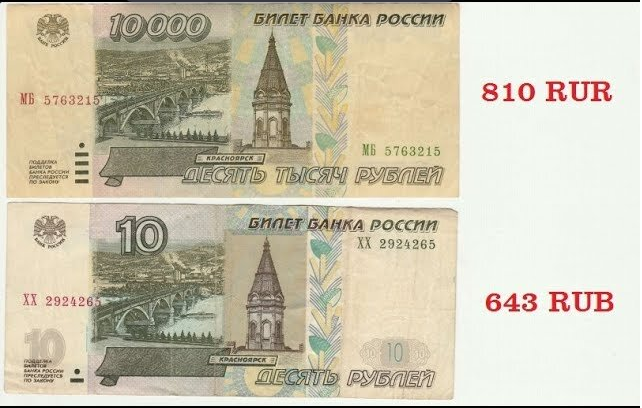

В виду смены Общероссийского классификатора валют (ОКВ) с 014-94 на 014-2000 в 2001 году, был введен дополнительный код "643", который, на тот момент, относился именно к деноминированному рублю.

А к 01.01.2004 года было принято решение о смене кодировки Российского рубля в международных стандартах с 810, на 643 код. 810 код рубля перестает свое существование.

В действительности внутри Российской Федерации до сих пор используется кодировка "810", которой больше не существует, только она получила название "признак рубля".

Используется она исключительно для удобства бухгалтерских и финансовых операций внутри страны. Для международных расчетных операций используются счета с формулировкой "643".

Добавим в таблицу с кодами валют информацию что под кодом 810 выступает российский рубль. Также отсутствовала информация по монете HRK (Хорватская Куна) c кодом 191.

In [32]:
val_table = pd.concat([val_table, pd.DataFrame({'num_code': [810, 191], 'currency_code':['RUR', 'HRK'],'title':['Russian ruble', 'Kuna']})], ignore_index=True)

In [33]:
val_table.tail()

,num_code,currency_code,title
176,967,ZMW,Zambian kwacha
177,924,ZWG,Zimbabwe Gold
178,932,ZWL,Zimbabwean dollar (2019–present)
179,810,RUR,Russian ruble
180,191,HRK,Kuna


In [34]:
data = df.merge(val_table, left_on='currency', right_on='num_code', how='left')
data.head()

,mcc,period,trdatetime,amount,cl_id,currency,trx_category,transac_time,transac_day,transac_month,transac_year,transac_year_month,num_code,currency_code,title
0,5200,2017-10-01,21OCT17:00:00:00,5023.0,0,810,POS,00:00:00,21,10,2017,2017-10,810,RUR,Russian ruble
1,6011,2017-10-01,12OCT17:12:24:07,20000.0,0,810,DEPOSIT,12:24:07,12,10,2017,2017-10,810,RUR,Russian ruble
2,5921,2017-12-01,05DEC17:00:00:00,767.0,0,810,POS,00:00:00,05,12,2017,2017-12,810,RUR,Russian ruble
3,5411,2017-10-01,21OCT17:00:00:00,2031.0,0,810,POS,00:00:00,21,10,2017,2017-10,810,RUR,Russian ruble
4,6012,2017-10-01,24OCT17:13:14:24,36562.0,0,810,C2C_OUT,13:14:24,24,10,2017,2017-10,810,RUR,Russian ruble


In [35]:
data.title.isna().sum()

0

In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1008889 entries, 0 to 1008888
Data columns (total 15 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   mcc                 1008889 non-null  int64         
 1   period              1008889 non-null  datetime64[ns]
 2   trdatetime          1008889 non-null  object        
 3   amount              1008889 non-null  float64       
 4   cl_id               1008889 non-null  int64         
 5   currency            1008889 non-null  int32         
 6   trx_category        1008889 non-null  object        
 7   transac_time        1008889 non-null  object        
 8   transac_day         1008889 non-null  object        
 9   transac_month       1008889 non-null  object        
 10  transac_year        1008889 non-null  object        
 11  transac_year_month  1008889 non-null  object        
 12  num_code            1008889 non-null  int64         
 13  currency_cod

Коды расшифрованы, рассмотрим статистику для валют заново

In [37]:
stat_val = data.groupby('title')['amount'].agg(['min', 'mean', 'median','max']).head()
stat_val

,min,mean,median,max
title,,,,
Argentine peso,55.00,2469.582308,560.000,17546.28
Armenian dram,200.00,22946.801210,9424.000,196000.00
Australian dollar,1.00,64.860000,16.885,502.00
Azerbaijani manat,1.70,126.424000,46.500,1321.92
Bahamian dollar,16.07,24.575000,24.575,33.08


Так например, среди имеющихся данных минимальная транзакция для Австралийского доллара составила 1.0, средняя сумма транцакзии составляет 64.86 в этой же валюте, половина транзакций составляют 16.9 и меньше, а максимальная транзакция 502.0

Рассмотри те же показатели для рубля, доллара и евро

In [38]:
data[(data['num_code'].isin([840, 978, 810]))].groupby('title')["amount"].agg(['min', 'mean', 'median','max'])

,min,mean,median,max
title,,,,
Euro,0.01,105.797974,29.00,9690.0
Russian ruble,0.01,5355.389108,649.00,4520000.0
United States dollar,0.01,173.517300,34.49,50000.0


### Расшифровка MCC-кодов

Код MCC - это стандартизированный код категории покупки, который устанавливается на кассы предприятия. Потом банки исходя из этих кодов могут начислять кэшбек или бонусы за проведенные транзакции, если это предуматривает Ваш тариф.

In [39]:
!pip install xlrd

In [40]:
mcc = pd.read_excel('mcc_codes.xls', skiprows=1)
mcc.head()

,MCC CODE,Program Type:,Unnamed: 2
0,742.0,Veterinary Services,NaN
1,763.0,Agricultural Cooperatives,NaN
2,780.0,Landscaping and Horticultural Services,NaN
3,1520.0,General Contractor/Residential Building,NaN
4,1711.0,"Heating, Plumbing, Air Conditioning Contractors",NaN


In [41]:
mcc = mcc.iloc[:,:-1]
mcc = mcc.rename(columns={'MCC CODE': 'mcc', 'Program Type:': 'category'})
mcc.head()

,mcc,category
0,742.0,Veterinary Services
1,763.0,Agricultural Cooperatives
2,780.0,Landscaping and Horticultural Services
3,1520.0,General Contractor/Residential Building
4,1711.0,"Heating, Plumbing, Air Conditioning Contractors"


Объединим таблицы data и mcc

In [42]:
data['mcc'] = data['mcc'].astype('int')
data = data.merge(mcc, how='left', on='mcc')
data.head()

,mcc,period,trdatetime,amount,cl_id,currency,trx_category,transac_time,transac_day,transac_month,transac_year,transac_year_month,num_code,currency_code,title,category
0,5200,2017-10-01,21OCT17:00:00:00,5023.0,0,810,POS,00:00:00,21,10,2017,2017-10,810,RUR,Russian ruble,Home Supply Warehouse
1,6011,2017-10-01,12OCT17:12:24:07,20000.0,0,810,DEPOSIT,12:24:07,12,10,2017,2017-10,810,RUR,Russian ruble,Financial Institutions--Automated Cash Disburs...
2,5921,2017-12-01,05DEC17:00:00:00,767.0,0,810,POS,00:00:00,05,12,2017,2017-12,810,RUR,Russian ruble,"Package Stores--Beer, Wine, and Liquor"
3,5411,2017-10-01,21OCT17:00:00:00,2031.0,0,810,POS,00:00:00,21,10,2017,2017-10,810,RUR,Russian ruble,Grocery Stores and Supermarkets
4,6012,2017-10-01,24OCT17:13:14:24,36562.0,0,810,C2C_OUT,13:14:24,24,10,2017,2017-10,810,RUR,Russian ruble,Quasi Cash - Financial Institution - Merchandi...


In [43]:
data.category.isna().value_counts()

category
False    1008888
True           1
Name: count, dtype: int64

Только в 1 случае категория не была определена

## Составление отчета по средним тратам

Для составления отчета отберем только рублевые транзакции и сделаем табличку в разрезе категория-даты.

Поскольку природа данных это покупки/транзакции, то присутствуют экстремальные значения, которые будут искажать среднее. Исходя из анализа уберем по 1% максимальных и минимальных процентов.

### Создание итоговой таблицы

In [44]:
report = pd.DataFrame()
currency = 810
rubbles = data[data['currency'] == currency]
dates = sorted(rubbles['transac_year_month'].unique())

In [45]:
for date in dates:
    mean_date = rubbles[rubbles['transac_year_month'] == date][['transac_year_month','amount','category']].set_index(['transac_year_month','category'])

    low = .01
    high = .99
    quant_df = mean_date.quantile([low, high])

    filtered_df = mean_date.apply(lambda x: x[(x>quant_df.loc[low, x.name]) & (x < quant_df.loc[high, x.name])], axis=0)
    filtered_df = filtered_df.reset_index().groupby(['transac_year_month','category']).mean()

    report = pd.concat([report, filtered_df])

In [46]:
report

amount
transac_year_month category                                                        
2016-10            Advertising Services                                 1166.836667
                   AeroFlot                                            29032.428571
                   Airlines and Air Carriers                           14314.431600
                   Amusement Parks, Circuses, Carnivals, and Fortu...  16597.500000
                   Antique Shop                                        16757.560000
...                                                                             ...
2018-04            Service Stations (with or without Ancillary Ser...   1409.586667
                   Sporting Goods Stores                                 490.000000
                   Theatrical Producers (except Motion Pictures) a...  30000.000000
                   Utilities-Electric, Gas, Water, and Sanitary         7632.680000
                   Variety Stores                                        114.190000

[3538 rows x 1 columns]

In [47]:
report = report.unstack().T
report = round(report,2)
report

transac_year_month                                       2016-10   2016-11  \
       category                                                              
amount AIR STANA                                             NaN       NaN   
       Accounting, Auditing, and Bookkeeping Services        NaN   2294.42   
       Advertising Services                              1166.84   2088.40   
       AeroFlot                                         29032.43  27261.75   
       Agricultural Cooperatives                             NaN       NaN   
...                                                          ...       ...   
       Watch, Clock, and Jewelry Repair Shops                NaN       NaN   
       Wholesale Club with or without membership fee    12276.22   8403.27   
       Wig & Toupee Shops                                    NaN       NaN   
       Women's Accessory and Specialty Stores            1228.40   6439.13   
       Women's Ready-to-Wear Stores                      8233.03   7631.53   

transac_year_month                                       2016-12   2017-01  \
       category                                                              
amount AIR STANA                                             NaN  14061.00   
       Accounting, Auditing, and Bookkeeping Services        NaN    960.00   
       Advertising Services                              1454.69   1103.79   
       AeroFlot                                         25535.48  21349.45   
       Agricultural Cooperatives                             NaN    702.00   
...                                                          ...       ...   
       Watch, Clock, and Jewelry Repair Shops                NaN       NaN   
       Wholesale Club with or without membership fee     7234.40   8976.94   
       Wig & Toupee Shops                                    NaN   2000.00   
       Women's Accessory and Specialty Stores            2582.78   2734.79   
       Women's Ready-to-Wear Stores                      6547.30   6427.50   

transac_year_month                                       2017-02   2017-03  \
       category                                                              
amount AIR STANA                                        10977.00       NaN   
       Accounting, Auditing, and Bookkeeping Services        NaN       NaN   
       Advertising Services                               975.35   1049.57   
       AeroFlot                                         22809.59  27817.21   
       Agricultural Cooperatives                          624.00       NaN   
...                                                          ...       ...   
       Watch, Clock, and Jewelry Repair Shops                NaN       NaN   
       Wholesale Club with or without membership fee     6758.63   5218.67   
       Wig & Toupee Shops                                    NaN       NaN   
       Women's Accessory and Specialty Stores            3487.55   2966.96   
       Women's Ready-to-Wear Stores                      7061.39   7582.02   

transac_year_month                                       2017-04   2017-05  \
       category                                                              
amount AIR STANA                                             NaN       NaN   
       Accounting, Auditing, and Bookkeeping Services        NaN    290.00   
       Advertising Services                              1638.89   1612.21   
       AeroFlot                                         19453.18  23651.27   
       Agricultural Cooperatives                         1879.50   1440.00   
...                                                          ...       ...   
       Watch, Clock, and Jewelry Repair Shops                NaN       NaN   
       Wholesale Club with or without membership fee     5344.77   6224.34   
       Wig & Toupee Shops                                    NaN       NaN   
       Women's Accessory and Specialty Stores            5260.47   5300.71   
       Women's Read

Для автоматизации создадим отдельную функцию, выполняющую действия, описанные выше

In [48]:
def do_report(dataframe, currency_int):

    report = pd.DataFrame()
    currency = currency_int
    df = dataframe[dataframe['currency'] == currency]
    dates = sorted(df['transac_year_month'].unique())


    for date in dates:
        mean_date = df[df['transac_year_month'] == date][['transac_year_month','amount','category']].set_index(['transac_year_month','category'])

        low = .01
        high = .99
        quant_df = mean_date.quantile([low, high])

        filtered_df = mean_date.apply(lambda x: x[(x>quant_df.loc[low,x.name]) & (x < quant_df.loc[high,x.name])], axis=0)
        filtered_df = filtered_df.reset_index().groupby(['transac_year_month','category']).mean()

        report = pd.concat([report, filtered_df])

    report = report.unstack().T

    if report.shape[0] == 0:
        report = pd.DataFrame() 
        for date in dates:
            mean_date = df[df['transac_year_month'] == date][['transac_year_month','amount','category']].set_index(['transac_year_month','category'])
            mean_date =  mean_date.groupby(['transac_year_month','category']).mean()
            report = pd.concat([report, buffer])
            return round(report,2)
    else:
        return round(report,2)

In [49]:
report = do_report(data, 810)
report

transac_year_month                                       2016-10   2016-11  \
       category                                                              
amount AIR STANA                                             NaN       NaN   
       Accounting, Auditing, and Bookkeeping Services        NaN   2294.42   
       Advertising Services                              1166.84   2088.40   
       AeroFlot                                         29032.43  27261.75   
       Agricultural Cooperatives                             NaN       NaN   
...                                                          ...       ...   
       Watch, Clock, and Jewelry Repair Shops                NaN       NaN   
       Wholesale Club with or without membership fee    12276.22   8403.27   
       Wig & Toupee Shops                                    NaN       NaN   
       Women's Accessory and Specialty Stores            1228.40   6439.13   
       Women's Ready-to-Wear Stores                      8233.03   7631.53   

transac_year_month                                       2016-12   2017-01  \
       category                                                              
amount AIR STANA                                             NaN  14061.00   
       Accounting, Auditing, and Bookkeeping Services        NaN    960.00   
       Advertising Services                              1454.69   1103.79   
       AeroFlot                                         25535.48  21349.45   
       Agricultural Cooperatives                             NaN    702.00   
...                                                          ...       ...   
       Watch, Clock, and Jewelry Repair Shops                NaN       NaN   
       Wholesale Club with or without membership fee     7234.40   8976.94   
       Wig & Toupee Shops                                    NaN   2000.00   
       Women's Accessory and Specialty Stores            2582.78   2734.79   
       Women's Ready-to-Wear Stores                      6547.30   6427.50   

transac_year_month                                       2017-02   2017-03  \
       category                                                              
amount AIR STANA                                        10977.00       NaN   
       Accounting, Auditing, and Bookkeeping Services        NaN       NaN   
       Advertising Services                               975.35   1049.57   
       AeroFlot                                         22809.59  27817.21   
       Agricultural Cooperatives                          624.00       NaN   
...                                                          ...       ...   
       Watch, Clock, and Jewelry Repair Shops                NaN       NaN   
       Wholesale Club with or without membership fee     6758.63   5218.67   
       Wig & Toupee Shops                                    NaN       NaN   
       Women's Accessory and Specialty Stores            3487.55   2966.96   
       Women's Ready-to-Wear Stores                      7061.39   7582.02   

transac_year_month                                       2017-04   2017-05  \
       category                                                              
amount AIR STANA                                             NaN       NaN   
       Accounting, Auditing, and Bookkeeping Services        NaN    290.00   
       Advertising Services                              1638.89   1612.21   
       AeroFlot                                         19453.18  23651.27   
       Agricultural Cooperatives                         1879.50   1440.00   
...                                                          ...       ...   
       Watch, Clock, and Jewelry Repair Shops                NaN       NaN   
       Wholesale Club with or without membership fee     5344.77   6224.34   
       Wig & Toupee Shops                                    NaN       NaN   
       Women's Accessory and Specialty Stores            5260.47   5300.71   
       Women's Read

### Создание итоговой отчетности в Excel

Создадим функцию записи каждой категории транзакций на отдельном листе в Excel

In [50]:
import openpyxl
from openpyxl.utils.dataframe import dataframe_to_rows

Создадим функцию, которая циклично добавляет табличку на новый лист с названием этой таблицы.

In [51]:
def write_excel(dataframe, dataframe_name):
  writer = pd.ExcelWriter('report.xlsx', engine='openpyxl', mode="a")

  dataframe.to_excel(writer, '{}'.format(str(dataframe_name)))
  writer.close()

In [52]:
trx_cats = data[data['currency'] == 810]['trx_category'].unique()

In [53]:
filepath = ""
book = openpyxl.Workbook()
book.save(filepath+'report.xlsx')

Создаем цикл создания отчетов и записи в Excel файл

In [54]:
for trx_cat in trx_cats:
    report = do_report(data[data['trx_category'] == trx_cat], 810)
    write_excel(report, '{}'.format(trx_cat))

## Отчет по оттоку

**Отток клиентов (Churn)** — это потеря клиентов. 

Необходимо посчитать месячный отток, то есть проверить сколько людей уходили в текущий месяц, сравнивая его с предыдущим.

Таким образом, будем искать оттекших пользователей, то есть cl_id, которых нет в этом месяце, но есть в прошлом.

In [55]:
data.head(3)

,mcc,period,trdatetime,amount,cl_id,currency,trx_category,transac_time,transac_day,transac_month,transac_year,transac_year_month,num_code,currency_code,title,category
0,5200,2017-10-01,21OCT17:00:00:00,5023.0,0,810,POS,00:00:00,21,10,2017,2017-10,810,RUR,Russian ruble,Home Supply Warehouse
1,6011,2017-10-01,12OCT17:12:24:07,20000.0,0,810,DEPOSIT,12:24:07,12,10,2017,2017-10,810,RUR,Russian ruble,Financial Institutions--Automated Cash Disburs...
2,5921,2017-12-01,05DEC17:00:00:00,767.0,0,810,POS,00:00:00,05,12,2017,2017-12,810,RUR,Russian ruble,"Package Stores--Beer, Wine, and Liquor"


In [56]:
churn_array = []

for month in sorted(data['transac_year_month'].unique()):
    try:
        current = data[data['transac_year_month'] == month]['cl_id'].unique()
        churned_idx = np.isin(previous_month, current, invert=True)
        churned = previous_month[churned_idx]
        churn_array.append(len(churned))
        previous_month = current
    except NameError:
        churn_array.append(np.nan)
        previous_month = data[data['transac_year_month'] == month]['cl_id'].unique()

In [57]:
churn_table = pd.DataFrame({'months':sorted(data['transac_year_month'].unique()),
                            'churn':churn_array}, columns=['months','churn'])
churn_table

,months,churn
0,2016-10,NaN
1,2016-11,21.0
2,2016-12,107.0
3,2017-01,313.0
4,2017-02,919.0
5,2017-03,1220.0
6,2017-04,1155.0
7,2017-05,595.0
8,2017-06,841.0
9,2017-07,946.0


**График оттока пользователей**

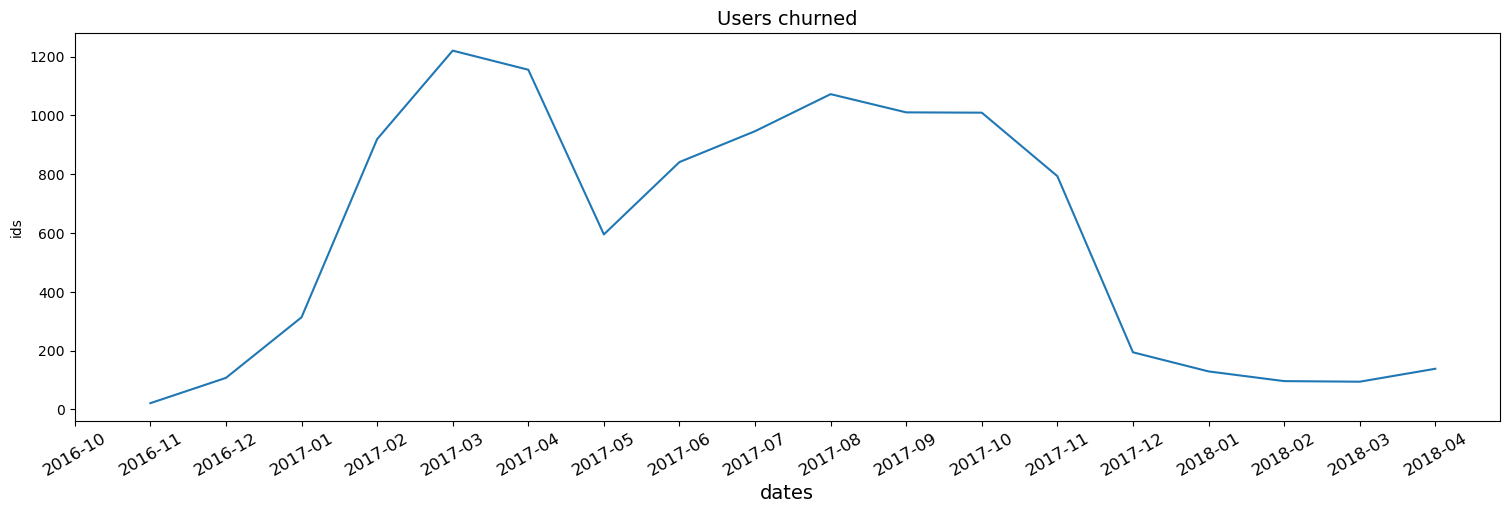

In [58]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(15,5))
churn_table['churn'].plot()

plt.xlabel('dates', fontsize=14)
ax = plt.gca()
plt.xticks(np.arange(0, len(dates), 1.0))
ax.set_xticklabels(churn_table['months'], fontsize=12, rotation=30)
plt.tight_layout()

plt.ylabel('ids')
plt.title('Users churned', fontsize=14)
plt.show()